# 総合実験（４日目）

## 〜 IPython Notebook (Jupyter Notebook)を使った機械学習 〜

### IPython Notebook とは
* Python という名のプログラミング言語が使えるプログラミング環境。計算コードと計算結果を同じ場所に時系列で保存できるので、実験系における実験ノートのように、いつどんな処理を行って何を得たのか記録して再現するのに便利。
* [Jupyter Notebook（IPython）のインストールと始め方](http://www.task-notes.com/entry/20151129/1448794509)
* [小寺研究室](https://github.com/maskot1977/-/blob/master/L1%E3%82%BC%E3%83%9F2015%E5%B0%8F%E5%AF%BA%E7%A0%94%E7%A9%B6%E5%AE%A4.pptx.pdf) では、MacOSX上で右記のようにセットアップして使っています。> [環境構築](https://sites.google.com/site/masaakikotera/8-python/8-1-huan-jing-gou-zhu)

### 前回の復習
* 前回の内容を忘れてしまった人は[総合実験（３日目）](http://nbviewer.jupyter.org/github/maskot1977/ipython_notebook/blob/master/%E7%B7%8F%E5%90%88%E5%AE%9F%E9%A8%93%EF%BC%93%E6%97%A5%E7%9B%AE.ipynb) を見てください。

### 本実習スタート
* 本実習では、人工知能の一分野である「機械学習」のうち、サポートベクトルマシン（SVM: Support Vector Machine）を使います。
   * 機械学習とは→ [コンピューターに"学習"させる](http://image.slidesharecdn.com/deepvision-141031063609-conversion-gate01/95/deep-learning-4-638.jpg) 
   * [サポートベクターマシン](http://image.slidesharecdn.com/shen2007-120927221259-phpapp01/95/proteinprotein-interaction-prediction-8-728.jpg) ・ [サポートベクターマシンとは](http://qiita.com/pesuchin/items/c55f40b69aa1aec2bd19)
* 各自の画面中の IPython Notebook のセルに順次入力して（コピペ可）、「Shift + Enter」してください。
* 最後に、課題を解いてもらいます。課題の結果を、指定する方法で指定するメールアドレスまで送信してください。

In [1]:
import matplotlib.pyplot as plt # 図やグラフを図示するためのライブラリ
import pylab as pl # これも図やグラフを図示するためのライブラリ

#　Jupiter Notebook 上で表示させるための呪文
%matplotlib inline 

import urllib # URL によるリソースへのアクセスを提供するライブラリ

import random #乱数を発生させるライブラリ
import numpy as np # 数値計算ライブラリ

import pandas as pd # データフレームワーク処理のライブラリ
from pandas.tools import plotting # 高度なプロットを行うツールのインポート

#機械学習のためのいろんなライブラリ
import sklearn.svm as svm
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report, confusion_matrix
from sklearn import cross_validation as cv
from sklearn import svm, grid_search, datasets

総合実験１日目でも用いたデータをまた使います。

In [2]:
# ウェブ上のリソースを指定する
url = 'https://dl.dropboxusercontent.com/u/432512/20120210/data/iris.txt'
# 指定したURLからリソースをダウンロードし、名前をつける。
urllib.urlretrieve(url, 'iris.txt')

('iris.txt', <httplib.HTTPMessage instance at 0x116eae638>)

とりあえずデータを確認するには、こんな方法もあります

In [3]:
# 先頭N行を表示する。カラムのタイトルも確認する。
pd.DataFrame(pd.read_csv('iris.txt', sep='\t', na_values=".")).head() 

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


### 色分けした Scatter Matrix を描く
* 今回は、"Species" 毎に色を変えてプロットしたいと思います。
* カラーコードが分からない人は右記リンク参照→ [カラーコード表](http://www5.plala.or.jp/vaio0630/hp/c_code.htm)・[カラーコード](http://www.finitojapan.com/cltable.html)

In [4]:
# "Species" 列の値を重複を除いて全てリストアップする。
print list(set(pd.read_csv('iris.txt', sep='\t', na_values=".")["Species"]))

['setosa', 'versicolor', 'virginica']


In [5]:
# それぞれに与える色を決める。
color_codes = {'setosa':'#00FF00', 'versicolor':'#FF0000', 'virginica':'#0000FF'}

In [6]:
# サンプル毎に色を与える。
colors = [color_codes[x] for x in list(pd.read_csv('iris.txt', sep='\t', na_values=".")["Species"])]

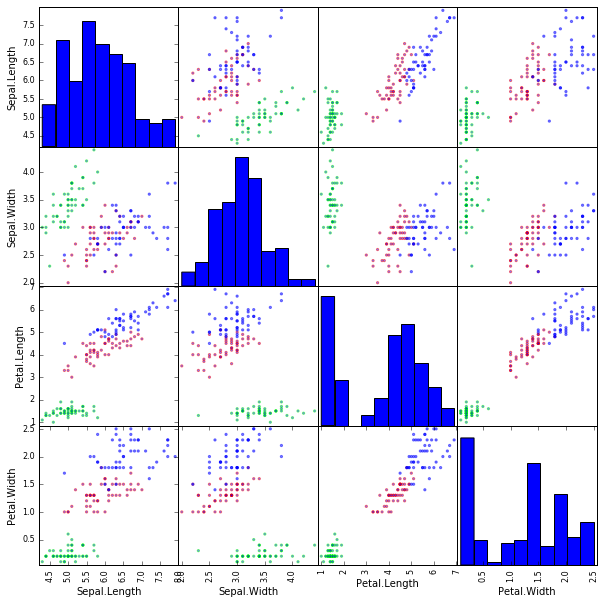

In [7]:
# 色分けした Scatter Matrix を描く。
df = pd.read_csv('iris.txt', sep='\t', na_values=".") # データの読み込み
plotting.scatter_matrix(df[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']], figsize=(10, 10), color=colors)   #データのプロット
plt.show()

### データの整形
Nをサンプル数、Mを特徴量の数とする。__data__から__target__を予測する問題を解く。
* __feature_names__ : 特徴量の名前（M次元のベクトル）
* __sample_names__ : サンプルの名前（N次元のベクトル）
* __target_names__ : 目的変数の名前（N次元のベクトル）
* __data__ : 説明変数（N行M列の行列）
* __target__ : 目的変数（N次元のベクトル）

In [8]:
# 説明変数と目的変数に分ける。
data = []
target = []
feature_names = []
sample_names = []
target_names = []
for i, line in enumerate(open("iris.txt")):
    a = line.replace("\n", "").split("\t")
    if i == 0:
        for j, word in enumerate(a):
            if j == 0:
                continue
            elif j == len(a) - 1:
                continue
            else:
                feature_names.append(word)
    else:
        vec = []
        for j, word in enumerate(a):
            if j == 0:
                sample_names.append(word)
            elif j == len(a) - 1:
                word = word.strip()
                if word not in target_names:
                    target_names.append(word)
                target.append(target_names.index(word))
            else:
                vec.append(float(word))
        data.append(vec)

In [9]:
# 名前の確認
print feature_names
print sample_names
print target_names

['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '

In [10]:
# 説明変数の確認
print data

[[5.1, 3.5, 1.4, 0.2], [4.9, 3.0, 1.4, 0.2], [4.7, 3.2, 1.3, 0.2], [4.6, 3.1, 1.5, 0.2], [5.0, 3.6, 1.4, 0.2], [5.4, 3.9, 1.7, 0.4], [4.6, 3.4, 1.4, 0.3], [5.0, 3.4, 1.5, 0.2], [4.4, 2.9, 1.4, 0.2], [4.9, 3.1, 1.5, 0.1], [5.4, 3.7, 1.5, 0.2], [4.8, 3.4, 1.6, 0.2], [4.8, 3.0, 1.4, 0.1], [4.3, 3.0, 1.1, 0.1], [5.8, 4.0, 1.2, 0.2], [5.7, 4.4, 1.5, 0.4], [5.4, 3.9, 1.3, 0.4], [5.1, 3.5, 1.4, 0.3], [5.7, 3.8, 1.7, 0.3], [5.1, 3.8, 1.5, 0.3], [5.4, 3.4, 1.7, 0.2], [5.1, 3.7, 1.5, 0.4], [4.6, 3.6, 1.0, 0.2], [5.1, 3.3, 1.7, 0.5], [4.8, 3.4, 1.9, 0.2], [5.0, 3.0, 1.6, 0.2], [5.0, 3.4, 1.6, 0.4], [5.2, 3.5, 1.5, 0.2], [5.2, 3.4, 1.4, 0.2], [4.7, 3.2, 1.6, 0.2], [4.8, 3.1, 1.6, 0.2], [5.4, 3.4, 1.5, 0.4], [5.2, 4.1, 1.5, 0.1], [5.5, 4.2, 1.4, 0.2], [4.9, 3.1, 1.5, 0.2], [5.0, 3.2, 1.2, 0.2], [5.5, 3.5, 1.3, 0.2], [4.9, 3.6, 1.4, 0.1], [4.4, 3.0, 1.3, 0.2], [5.1, 3.4, 1.5, 0.2], [5.0, 3.5, 1.3, 0.3], [4.5, 2.3, 1.3, 0.3], [4.4, 3.2, 1.3, 0.2], [5.0, 3.5, 1.6, 0.6], [5.1, 3.8, 1.9, 0.4], [4.8, 3.0

In [11]:
# 応答変数の確認
print target

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


### データのシャッフル
* 今のままだと、同じ目的変数同士でサンプルが固まっているので、サンプルの順番をランダムに入れ替えます。

In [12]:
# データをシャッフルする
p = range(len(sample_names))
random.seed(0)
random.shuffle(p)
sample_names = list(np.array(sample_names)[p])
data = np.array(data)[p]
target = list(np.array(target)[p])

In [13]:
# シャッフル後のデータを確認
print sample_names

['137', '29', '14', '142', '99', '138', '111', '125', '118', '40', '80', '91', '9', '70', '4', '139', '101', '55', '30', '17', '23', '3', '130', '135', '26', '61', '120', '108', '78', '73', '121', '21', '110', '100', '19', '33', '22', '115', '28', '144', '150', '143', '79', '105', '10', '6', '133', '12', '42', '69', '102', '114', '5', '43', '77', '62', '88', '72', '106', '90', '36', '56', '109', '134', '18', '47', '132', '123', '140', '148', '126', '67', '65', '57', '7', '37', '84', '82', '15', '16', '24', '48', '97', '86', '38', '51', '53', '136', '96', '74', '50', '66', '52', '11', '89', '49', '32', '8', '45', '81', '98', '25', '145', '20', '92', '35', '27', '94', '124', '1', '146', '93', '46', '141', '2', '64', '129', '31', '103', '58', '117', '112', '76', '54', '13', '60', '87', '116', '95', '41', '119', '107', '131', '122', '34', '85', '104', '147', '71', '128', '83', '68', '44', '149', '59', '75', '39', '63', '113', '127']


In [14]:
# シャッフル後のデータを確認
print data

[[ 6.3  3.4  5.6  2.4]
 [ 5.2  3.4  1.4  0.2]
 [ 4.3  3.   1.1  0.1]
 [ 6.9  3.1  5.1  2.3]
 [ 5.1  2.5  3.   1.1]
 [ 6.4  3.1  5.5  1.8]
 [ 6.5  3.2  5.1  2. ]
 [ 6.7  3.3  5.7  2.1]
 [ 7.7  3.8  6.7  2.2]
 [ 5.1  3.4  1.5  0.2]
 [ 5.7  2.6  3.5  1. ]
 [ 5.5  2.6  4.4  1.2]
 [ 4.4  2.9  1.4  0.2]
 [ 5.6  2.5  3.9  1.1]
 [ 4.6  3.1  1.5  0.2]
 [ 6.   3.   4.8  1.8]
 [ 6.3  3.3  6.   2.5]
 [ 6.5  2.8  4.6  1.5]
 [ 4.7  3.2  1.6  0.2]
 [ 5.4  3.9  1.3  0.4]
 [ 4.6  3.6  1.   0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 7.2  3.   5.8  1.6]
 [ 6.1  2.6  5.6  1.4]
 [ 5.   3.   1.6  0.2]
 [ 5.   2.   3.5  1. ]
 [ 6.   2.2  5.   1.5]
 [ 7.3  2.9  6.3  1.8]
 [ 6.7  3.   5.   1.7]
 [ 6.3  2.5  4.9  1.5]
 [ 6.9  3.2  5.7  2.3]
 [ 5.4  3.4  1.7  0.2]
 [ 7.2  3.6  6.1  2.5]
 [ 5.7  2.8  4.1  1.3]
 [ 5.7  3.8  1.7  0.3]
 [ 5.2  4.1  1.5  0.1]
 [ 5.1  3.7  1.5  0.4]
 [ 5.8  2.8  5.1  2.4]
 [ 5.2  3.5  1.5  0.2]
 [ 6.8  3.2  5.9  2.3]
 [ 5.9  3.   5.1  1.8]
 [ 5.8  2.7  5.1  1.9]
 [ 6.   2.9  4.5  1.5]
 [ 6.5  3. 

In [15]:
# シャッフル後のデータを確認
print target

[2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 1, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 2, 0, 1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 2]


### データの分割
交差検定をするため、データを学習用とテスト用に分割します。
* __data_train__ :  説明変数（学習用）
* __data_test__ : 説明変数（テスト用）
* __target_train__ : 目的変数（学習用）
* __target_test__ :  目的変数（テスト用）

交差検定 (cross-validation) とは → [交差検定](http://image.slidesharecdn.com/scikit-learn-141201042924-conversion-gate01/95/scikit-learn-15-638.jpg)
* 現在取得できているデータを「学習用」と「テスト用」に分け、「学習用」だけを使って予測モデルを構築し、「評価用」を使ってモデルの性能を評価する。

In [16]:
# データを分割。test_size=0.8 は、学習：テスト のデータ量比が 2:8 であることを指す。
data_train, data_test, target_train, target_test, sample_names_train, sample_names_test = train_test_split(
    data, target, sample_names, test_size=0.8, random_state=0)

In [17]:
# 分割後のデータの確認（学習用）
print sample_names_train
print target_train
print data_train

['4', '76', '17', '73', '119', '69', '104', '81', '97', '16', '64', '75', '65', '82', '61', '48', '83', '44', '144', '106', '96', '126', '136', '22', '3', '40', '20', '123', '31', '12']
[0, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0]
[[ 4.6  3.1  1.5  0.2]
 [ 6.6  3.   4.4  1.4]
 [ 5.4  3.9  1.3  0.4]
 [ 6.3  2.5  4.9  1.5]
 [ 7.7  2.6  6.9  2.3]
 [ 6.2  2.2  4.5  1.5]
 [ 6.3  2.9  5.6  1.8]
 [ 5.5  2.4  3.8  1.1]
 [ 5.7  2.9  4.2  1.3]
 [ 5.7  4.4  1.5  0.4]
 [ 6.1  2.9  4.7  1.4]
 [ 6.4  2.9  4.3  1.3]
 [ 5.6  2.9  3.6  1.3]
 [ 5.5  2.4  3.7  1. ]
 [ 5.   2.   3.5  1. ]
 [ 4.6  3.2  1.4  0.2]
 [ 5.8  2.7  3.9  1.2]
 [ 5.   3.5  1.6  0.6]
 [ 6.8  3.2  5.9  2.3]
 [ 7.6  3.   6.6  2.1]
 [ 5.7  3.   4.2  1.2]
 [ 7.2  3.2  6.   1.8]
 [ 7.7  3.   6.1  2.3]
 [ 5.1  3.7  1.5  0.4]
 [ 4.7  3.2  1.3  0.2]
 [ 5.1  3.4  1.5  0.2]
 [ 5.1  3.8  1.5  0.3]
 [ 7.7  2.8  6.7  2. ]
 [ 4.8  3.1  1.6  0.2]
 [ 4.8  3.4  1.6  0.2]]


In [18]:
# 分割後のデータの確認（テスト用）
print sample_names_test
print target_test
print data_test

['2', '109', '100', '94', '125', '98', '150', '53', '84', '67', '34', '114', '57', '77', '134', '115', '15', '50', '6', '101', '112', '132', '26', '118', '87', '130', '10', '8', '11', '120', '147', '38', '108', '116', '131', '90', '30', '86', '56', '52', '46', '14', '68', '105', '80', '36', '129', '59', '58', '124', '148', '85', '88', '24', '54', '122', '27', '39', '102', '63', '51', '121', '25', '89', '18', '74', '66', '60', '42', '70', '93', '49', '23', '139', '5', '142', '127', '45', '111', '140', '1', '32', '9', '145', '117', '92', '95', '133', '91', '146', '13', '143', '113', '29', '141', '128', '79', '99', '41', '55', '28', '138', '43', '149', '35', '137', '19', '78', '62', '37', '33', '135', '7', '21', '103', '72', '107', '47', '110', '71']
[0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0

### SVMで学習・予測
学習用データ（ __data_train__ と __target_train__ ) の関係を学習して、テスト用データ( __data_test__ )から正解( __target_test__ ) を予測する、という流れになります。

In [19]:
# Linear SVM で学習・予測
classifier = svm.SVC(kernel='linear', probability=True)
#probas = classifier.fit(data_train, target_train).predict_proba(data_test)
pred = classifier.fit(data_train, target_train).predict(data_test)

In [20]:
# 予測結果
pd.DataFrame(pred).T

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0,2,1,1,2,1,1,1,1,1,...,0,1,0,0,2,1,1,0,2,1


In [21]:
#正解
pd.DataFrame(target_test).T

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0,2,1,1,2,1,2,1,1,1,...,0,2,0,0,2,1,2,0,2,1


### 予測モデルの評価
性能評価の指標はたくさんありますが、とりあえず３つは覚えておいてください。
* 正解率 (Accuracy) = (TP + TN) / (TP + FP + FN + TN)
* 適合率 (Precision) = TP / (TP + FP)
* 再現率 (Recall) = TP / (TP + FN)
* 特異度 (Specificity) = TN / (TN + FP)

参考資料は右記→ [モデルの評価](http://image.slidesharecdn.com/random-140419010313-phpapp02/95/-23-638.jpg)

### 混同行列 (confusion matrix)
データの分類で、うまくできた・できなかった回数を数えた表

In [22]:
# 予測と正解の比較。第一引数が行、第二引数が列を表す。
pd.DataFrame(confusion_matrix(pred, target_test))

,0,1,2
0,39,0,0
1,0,38,18
2,0,0,25


### 正解率 (Accuracy) の計算

In [23]:
# cv=5 で５分割クロスバリデーションし精度を計算
score=cv.cross_val_score(classifier,data,target,cv=5,n_jobs=-1)
print("Accuracy: {0:04.4f} (+/- {1:04.4f})".format(score.mean(),score.std()))

Accuracy: 0.9667 (+/- 0.0365)


### AUPRスコア と AUCスコア
性能評価によく使われるのがAUPRスコアとAUCスコア
* __AUPRスコア__ : Precision-Recallカーブ下の面積。 → [Precision-Recallカーブの例](http://image.slidesharecdn.com/prmu201512slideshare-151222104106/95/201512prmu-80-638.jpg)
* __AUCスコア__ : ROCカーブ下の面積。→ [ROC曲線](http://image.slidesharecdn.com/collaborativefilteringwithr-130416090214-phpapp02/95/collaborativefilteringwith-r-29-638.jpg)・[ROC曲線](http://image.slidesharecdn.com/iir08ver-1-0-090405123213-phpapp02/95/iir-08-ver10-28-728.jpg)

In [24]:
# AUPR や AUC スコアを出そうと思ったらターゲットをバイナリ（二値）にしないといけないっぽい。
# そこで、ラベルが2のものを無視して、ラベル0のものとラベル1のものを区別する。
data2 = []
target2 = []
for da, ta in zip(data, target):
    if ta == 2:
        continue
    data2.append(da)
    target2.append(ta)

In [25]:
# 二値になっていることを確認
print target2

[0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]


In [26]:
# データをシャッフル
p = range(len(data2))
random.seed(0)
random.shuffle(p)
sample_names = list(np.array(sample_names)[p])
data2 = np.array(data2)[p]
target2 = list(np.array(target2)[p])

In [27]:
# データを分割。test_size=0.8 は、学習：テスト のデータ量比が 2:8 であることを指す。
data_train, data_test, target_train, target_test, sample_names_train, sample_names_test = train_test_split(
    data2, target2, sample_names, test_size=0.8, random_state=0)

In [28]:
# Linear SVM で学習・予測
classifier = svm.SVC(kernel='linear', probability=True)
probas = classifier.fit(data_train, target_train).predict_proba(data_test)
pred = classifier.fit(data_train, target_train).predict(data_test)

In [29]:
# AUPR score を出す。ラベル0とラベル1の区別は簡単
precision, recall, thresholds = precision_recall_curve(target_test, probas[:, 1])
area = auc(recall, precision)
print "AUPR score: %0.2f" % area

AUPR score: 1.00


In [30]:
# AUC scoreを出す。ラベル0とラベル1の区別は簡単
fpr, tpr, thresholds = roc_curve(target_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
print "AUC score: %f" % roc_auc

AUC score: 1.000000


### 予測が簡単すぎてツマラナイので、もう少し難しくします。

In [31]:
# ラベルが0のものを無視して、ラベル1のものとラベル2のものを区別する。
# ラベルはバイナリ(0か1)でないといけないので、ここでは1のものを0と呼び、2のものを1と呼ぶように変換する。
data2 = []
target2 = []
for da, ta in zip(data, target):
    if ta == 0:
        continue
    data2.append(da)
    target2.append(ta - 1)

In [32]:
# データをシャッフル
p = range(len(data2))
random.seed(0)
random.shuffle(p)
shuffled_sample_names = list(np.array(sample_names)[p])
shuffled_data = np.array(data2)[p]
shuffled_target = list(np.array(target2)[p])

In [33]:
# データを分割。test_size=0.8 は、学習：テスト のデータ量比が 2:8 であることを指す。
data_train, data_test, target_train, target_test, sample_names_train, sample_names_test = train_test_split(
    data2, target2, sample_names, test_size=0.8, random_state=0)

In [34]:
# Linear SVM で学習・予測
classifier = svm.SVC(kernel='linear', probability=True)
probas = classifier.fit(data_train, target_train).predict_proba(data_test)
pred = classifier.fit(data_train, target_train).predict(data_test)

In [35]:
# AUPRスコアを出す
precision, recall, thresholds = precision_recall_curve(target_test, probas[:, 1])
area = auc(recall, precision)
print "Area Under Curve: %0.2f" % area

Area Under Curve: 0.99


In [36]:
# AUCスコアを出す。
fpr, tpr, thresholds = roc_curve(target_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

Area under the ROC curve : 0.988743


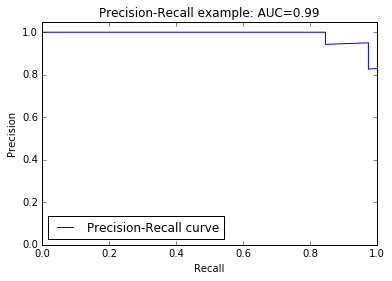

In [37]:
# PR curve を描く
pl.clf()
pl.plot(recall, precision, label='Precision-Recall curve')
pl.xlabel('Recall')
pl.ylabel('Precision')
pl.ylim([0.0, 1.05])
pl.xlim([0.0, 1.0])
pl.title('Precision-Recall example: AUC=%0.2f' % area)
pl.legend(loc="lower left")
pl.show()

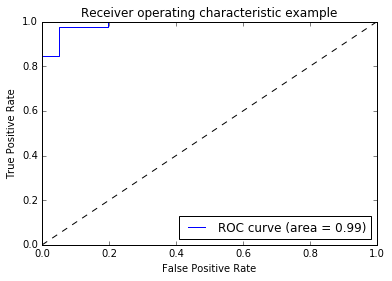

In [38]:
# ROC curve を描く
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

### まだ予測が簡単すぎてツマラナイので、さらに難しくします。

In [39]:
# 予測を難しくするため、不要な特徴量（ノイズ）を加える
np.random.seed(0)
data2 = np.c_[data2, np.random.randn(len(target2), 96)]

In [40]:
# 新しいデータを確認。
# 左の４列は元々のデータにあった数字なので、正しい分類に使える数字のはず。
# 右の96列はランダムなノイズなので、正しい分類には使えない数字のはず。
pd.DataFrame(data2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6.3,3.4,5.6,2.4,1.764052,0.400157,0.978738,2.240893,1.867558,-0.977278,...,1.178780,-0.179925,-1.070753,1.054452,-0.403177,1.222445,0.208275,0.976639,0.356366,0.706573
1,6.9,3.1,5.1,2.3,0.010500,1.785870,0.126912,0.401989,1.883151,-1.347759,...,-0.643618,-2.223403,0.625231,-1.602058,-1.104383,0.052165,-0.739563,1.543015,-1.292857,0.267051
2,5.1,2.5,3.0,1.1,-0.039283,-1.168093,0.523277,-0.171546,0.771791,0.823504,...,-2.030684,2.064493,-0.110541,1.020173,-0.692050,1.536377,0.286344,0.608844,-1.045253,1.211145
3,6.4,3.1,5.5,1.8,0.689818,1.301846,-0.628088,-0.481027,2.303917,-1.060016,...,0.049495,0.493837,0.643314,-1.570623,-0.206904,0.880179,-1.698106,0.387280,-2.255564,-1.022507
4,6.5,3.2,5.1,2.0,0.038631,-1.656715,-0.985511,-1.471835,1.648135,0.164228,...,-2.016407,-0.539455,-0.275671,-0.709728,1.738873,0.994394,1.319137,-0.882419,1.128594,0.496001
5,6.7,3.3,5.7,2.1,0.771406,1.029439,-0.908763,-0.424318,0.862596,-2.655619,...,0.354758,0.616887,0.008628,0.527004,0.453782,-1.829740,0.037006,0.767902,0.589880,-0.363859
6,7.7,3.8,6.7,2.2,-0.805627,-1.118312,-0.131054,1.133080,-1.951804,-0.659892,...,0.452489,0.097896,-0.448165,-0.649338,-0.023423,1.079195,-2.004216,0.376877,-0.545712,-1.884586
7,5.7,2.6,3.5,1.0,-1.945703,-0.912783,0.219510,0.393063,-0.938982,1.017021,...,0.039767,-1.566995,-0.451303,0.265688,0.723100,0.024612,0.719984,-1.102906,-0.101697,0.019279
8,5.5,2.6,4.4,1.2,1.849591,-0.214167,-0.499017,0.021351,-0.919113,0.192754,...,-1.032643,-0.436748,-1.642965,-0.406072,-0.535270,0.025405,1.154184,0.172504,0.021062,0.099454
9,5.6,2.5,3.9,1.1,0.227393,-1.016739,-0.114775,0.308751,-1.370760,0.865653,...,-0.947489,0.244443,1.401345,-0.410382,0.528944,0.246148,0.863520,-0.804754,2.346647,-1.279161


In [41]:
# データをシャッフル
p = range(len(data2))
random.seed(0)
random.shuffle(p)
shuffled_sample_names = list(np.array(sample_names)[p])
shuffled_data = np.array(data2)[p]
shuffled_target = list(np.array(target2)[p])

In [42]:
# データを分割。test_size=0.8 は、学習：テスト のデータ量比が 2:8 であることを指す。
data_train, data_test, target_train, target_test, sample_names_train, sample_names_test = train_test_split(
    data2, target2, sample_names, test_size=0.8, random_state=0)

In [43]:
# Linear SVM で学習・予測
classifier = svm.SVC(kernel='linear', probability=True)
probas = classifier.fit(data_train, target_train).predict_proba(data_test)
pred = classifier.fit(data_train, target_train).predict(data_test)

In [44]:
# AUPRスコアを出す
precision, recall, thresholds = precision_recall_curve(target_test, probas[:, 1])
area = auc(recall, precision)
print "AUPR score: %0.2f" % area

AUPR score: 0.69


In [45]:
# AUCスコアを出す
fpr, tpr, thresholds = roc_curve(target_test, probas[:, 1])
roc_auc = auc(fpr, tpr)
print "AUC curve : %f" % roc_auc

AUC curve : 0.689806


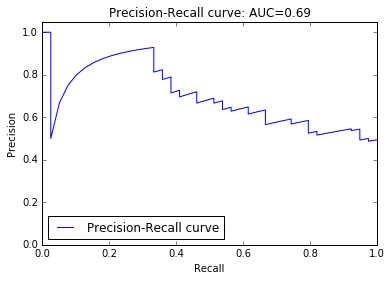

In [46]:
# PR curve を描く
pl.clf()
pl.plot(recall, precision, label='Precision-Recall curve')
pl.xlabel('Recall')
pl.ylabel('Precision')
pl.ylim([0.0, 1.05])
pl.xlim([0.0, 1.0])
pl.title('Precision-Recall curve: AUC=%0.2f' % area)
pl.legend(loc="lower left")
pl.show()

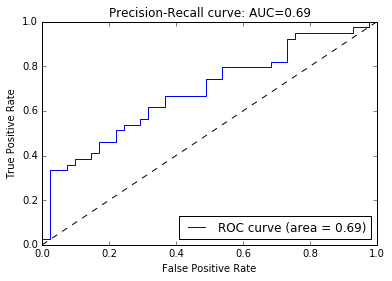

In [47]:
# ROC curve を描く
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Precision-Recall curve: AUC=%0.2f' % roc_auc)
pl.legend(loc="lower right")
pl.show()

ということで、分類に寄与しない余計な成分が増えると、分類が難しくなることが分かりましたね。
### グリッドサーチによるパラメータ最適化
グリッドサーチとは、機械学習モデルのハイパーパラメータをいろいろ変えながら予測と評価を繰り返し、最適なものを探す手法。

In [48]:
# グリッドサーチを行うためのパラメーター
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [49]:
# ベストなパラメーターを探し当てるためのグリッドサーチ
clf = grid_search.GridSearchCV(SVC(C=1), parameters, cv=5, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.best_estimator_)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [51]:
# 結果発表
scores = ['accuracy', 'precision', 'recall']

for score in scores:
    print '\n' + '='*50
    print score
    print '='*50

    clf = grid_search.GridSearchCV(SVC(C=1), parameters, cv=5, scoring=score, n_jobs=-1)
    clf.fit(data_train, target_train)

    print "\n+ ベストパラメータ:\n"
    print clf.best_estimator_

    print"\n+ トレーニングデータでCVした時の平均スコア:\n"
    for params, mean_score, all_scores in clf.grid_scores_:
        print "{:.3f} (+/- {:.3f}) for {}".format(mean_score, all_scores.std() / 2, params)

    print "\n+ テストデータでの識別結果:\n"
    target_true, target_pred = target_test, clf.predict(data_test)
    print classification_report(target_true, target_pred)


accuracy

+ ベストパラメータ:

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

+ トレーニングデータでCVした時の平均スコア:

0.550 (+/- 0.034) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.550 (+/- 0.034) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.700 (+/- 0.096) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.550 (+/- 0.034) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.700 (+/- 0.096) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.700 (+/- 0.096) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.700 (+/- 0.096) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.700 (+/- 0.096) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.700 (+/- 0.096) for {'kernel': 'linear', 'C': 1}
0.700 (+/- 0.096) for {'kernel': 'linear', 'C': 10}
0.700 (+/- 0.096) for {'kernel': 'linear', 'C': 100}
0.700 (+/- 0.096) for {'kernel': 'linear', 

----------
## 課題
新しいノートを開いて、以下の課題を解いてください。

* __課題1__：下記リンクのデータを用い、図1のような Scatter Matrix を描いてください。ただしこのとき、真札を青色、偽札を赤色にしてプロットすること。
   * https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/sbnote_dataJt.txt
   
      ここでは、以下の列を使います。
       * 'Note' : スイスフラン紙幣のID番号
       * 'length' : 横幅長
       * 'left': 左縦幅長
       * 'right': 右縦幅長
       * 'bottom': 下枠内長
       * 'top': 上枠内長
       * 'diagonal': 対角長
       * 'class': 0 = 真札、1= 偽札

* __課題2__： 上記のデータを使って学習し、サポートベクトルマシンを使って真札と偽札を区別する予測するモデルを構築し、その性能を正解率 (Accuracy) で評価してください。

以上の結果を [自分の氏名].ipynb ファイルとして保存し、指定したアドレスまでメールしてください。メールタイトルは「総合実験４日目」とし、メール本文に学籍番号と氏名を明記のこと。